# Computing vegetation indexes at scale using UP42

## Introduction

This notebook shows how indexes can be computed at scale using UP42. It relies on [gdal_calc](https://gdal.org/programs/gdal_calc.html). For doing the bulk of the work.

## Install the Python SDK
The module is called `up42`. Python **>= 3.7** is **required**.

 1. Create a virtual environment.
```bash
 mkvirtualenv --python=$(which python3) up42-py
```
 2. Activate the environment.
```bash
 workon up42-py
```
 3. Install the module.
 ```bash
 pip install up42-py
 ```
 4. Install Jupyter Lab.
```bash
 pip install jupyterlab
 ```
 5. Done.
 
Now we can just import it.

In [1]:
import up42

## Authenticate with project ID and project key
The project API key and the project ID are read from a JSON file.
This file has the following structure:

```json
{
  "project_id": "<your-project-ID-here>",
  "project_api_key": "<your-api-key-here>"
}
```
To know how to obtain the project API key and project ID the please refer to the [documentation](https://docs.up42.com/developers/guides/introduction#project-variables).

## Some suggested watching & reading for understanding vegetation indexes

* [NEON Science video on vegetation indexes](https://www.youtube.com/watch?v=4_EYPNI-A5g).
* [NEON Science document on Vegetation indexes](https://data.neonscience.org/api/v0/documents/NEON.DOC.002391vA).

Be aware that in this case they are discussing not only satellite imagery, but also aerial imagery with an spectrometer (Hyperspectral sensor).
We are using it here just with Sentinel 2 data, hence a much lower number of bands.

## Indexes we are computing

### NDVI

Normal Difference Vegetation Index.

$$NDVI = {NIR - Red \over NIR + Red}$$

### EVI

#### Enhanced Vegetation Index.

$$EVI= 2.5 \frac{NIR - Red}{NIR+ 6 Red-7.5 Blue+1}$$

### ARVI

#### Atmospherically Resistant Vegetation Index[]().

$$ARVI = \frac{NIR – 2 Red + Blue}{NIR + 2 Red + Blue}$$


### SAVI

#### Soil Adjusted Vegetation Index.

$$\mbox{SAVI}=\frac{1.5\,(NIR - Red)}{NIR + Red + 0.5}$$


For more indexes to be computed with Sentinel 2 please see this [article](https://www.tandfonline.com/doi/pdf/10.1080/22797254.2020.1839359).

## Using gdal_calc

[gdal_calc](https://gdal.org/programs/gdal_calc.html) is one of the utilities made available by the Geospatial Data Abstraction Library (GDAL) which is a C++ library to handle raster and vector files of geospatial data.

`gdal_calc` is a Python script that does computations on a set of files using [numpy formulas](https://numpy.org/doc/stable/reference/routines.html). The code is on [github](https://github.com/OSGeo/gdal/blob/206af6ca8e1d44448545ad367bdda172cbb22a95/gdal/swig/python/gdal-utils/osgeo_utils/gdal_calc.py).

Since `gdal_calc` is a script it will be run as a shell subprocess, thus things like paralellization of the index computation cannot be done easily since we we would be voiding caches each time we switched between threads. Real parallelization can be done by implementing the indexes yourself and using [Dask](https://docs.dask.org/en/latest/array.html) with [rasterio](https://rasterio.readthedocs.io/en/latest/) or just plain GDAL.

## Data source: Sentinel 2 L2A Analytic

The data block we'll be using is the [Sentinel 2 Analytic block](https://marketplace.up42.com/block/e13d8e92-2763-4640-80d6-1501b2729707). It returns a set of GeoTIFF files, each representing a band.

## Building the workflow and getting the data

### Authenticate & Create the workflow

In [2]:
# Reading the credentials from myconfig.json.
project_config_file = "/Users/appa/.up42/proj_default.conf" 
up42.authenticate(cfg_file = project_config_file)

2021-05-11 00:52:34,517 - Got credentials from config file.
2021-05-11 00:52:35,519 - Authentication with UP42 successful!


In [3]:
project = up42.initialize_project()

2021-05-11 00:52:36,565 - Initialized Project(name: Costumer calls, project_id: 5ea6a20d-4fa9-42a1-8e29-f2d9b27b0097, description: , createdAt: 2020-11-04T16:02:00.605788Z)


In [4]:
# Create the workflow
all_blocks = up42.get_blocks(basic = True)

2021-05-11 00:52:39,738 - Getting blocks name and id, use basic=False for all block details.


In [5]:
all_blocks

{'oneatlas-spot-aoiclipped': '045019bb-06fc-4fa1-b703-318725b4d8af',
 'tiling': '3e146dd6-2b67-4d6e-a422-bb3d973e32ff',
 'sobloo-s2-l1c-fullscene': '98c1acfa-c141-4095-b2e6-acf52d110178',
 'oneatlas-pleiades-aoiclipped': '18d09f1a-3197-4c27-a15a-54d099c31435',
 'sobloo-s1-grd-fullscene': 'b623400c-c5ac-40af-bda2-0d2734aa9dd1',
 'snap-polarimetric': '8c6baae9-d50e-406c-b4ac-e211caa6229d',
 'spacemetric-cloud-mask': '05796180-75ea-4194-a836-7bd2325457cc',
 'aiads_rgb_t3': '4123fe57-3b79-4b74-a6ef-f7bb9d08e028',
 'farearth/up42/house-detection': 'a09e65e0-4c57-415e-8a33-969a287d89af',
 'ship-detection': '79e3e48c-d65f-4528-a6d4-e8d20fecc93c',
 'sentinelhub-s2-aoiclipped': '018dfb34-fc19-4334-8125-14fd7535f979',
 'wind_turbines': 'e924d32d-cafa-45bf-a260-5eb0d0295750',
 'storage_tank': 'e271b0f9-afc8-45db-9c2e-037101ce5b53',
 'sentinelhub-landsat8-aoiclipped': '95519b2d-09d7-4cd0-a321-4d6a46bef6c1',
 'coreg': '6c379120-9789-448c-8ef0-bf80e9722f64',
 'qzsolutions.ndvi': 'b5b6ac43-287e-41ed-

In [6]:
my_tasks = ["esa-s2-l2a-gtiff-analytic", "pansharpen"]

In order to differentiate the workflow every time you run this cell or the full notebook we are going to add a date string to the workflow name. This string has the form: `yyyymmddhhmmss`.

In [7]:
import datetime as dt

In [8]:
now_str = dt.datetime.now().strftime("%Y%m%d%H%M%S")

In [9]:
workflow = project.create_workflow("S2 Analytic for scaling up indexes" + "-" + now_str)

2021-05-11 00:52:40,347 - Created new workflow: 9bd03113-cecb-45fa-9f19-72dd2faef51d


In [10]:
workflow.add_workflow_tasks(input_tasks = my_tasks)

2021-05-11 00:52:44,368 - Added tasks to workflow: [{'name': 'esa-s2-l2a-gtiff-analytic:1', 'parentName': None, 'blockId': 'e13d8e92-2763-4640-80d6-1501b2729707'}, {'name': 'pansharpen:1', 'parentName': 'esa-s2-l2a-gtiff-analytic:1', 'blockId': '903f0435-d638-475e-bbe9-53b5664a22a8'}]


In [11]:
aoi1 = up42.read_vector_file("/Users/appa/up42/a4f-2020/crop2cash/lekan_farm_list.geojson")

In [12]:
aoi2 = up42.read_vector_file("/Users/appa/up42/a4f-2020/growforme/newfarm.geojson")

In [13]:
aoi3 = up42.read_vector_file("/Users/appa/up42/a4f-2020/hehe/Juliet.geojson")

In [14]:
job_params = workflow.construct_parameters(geometry=aoi2, limit = 2, geometry_operation = "intersects")

In [15]:
job_params

{'esa-s2-l2a-gtiff-analytic:1': {'time': '2018-12-01T00:00:00+00:00/2021-12-31T23:59:59+00:00',
  'limit': 2,
  'max_cloud_cover': 100,
  'intersects': {'type': 'Polygon',
   'coordinates': (((-0.370332934, 9.5399165712),
     (-0.3703225404, 9.5399013162),
     (-0.3702095523, 9.5397178363),
     (-0.3701552376, 9.5395197719),
     (-0.3701060358, 9.5393981505),
     (-0.3700596839, 9.5393372979),
     (-0.369987851, 9.539319193),
     (-0.3699849173, 9.5392604358),
     (-0.370032778, 9.539225148),
     (-0.3699652199, 9.5389443543),
     (-0.3698068857, 9.5388172846),
     (-0.3697644733, 9.5387929771),
     (-0.3696550056, 9.5385682583),
     (-0.3694897145, 9.538446134),
     (-0.3693311289, 9.5383158792),
     (-0.3690511733, 9.5383276977),
     (-0.3687391989, 9.5383359957),
     (-0.3686443157, 9.5383379236),
     (-0.368376011, 9.5383129455),
     (-0.3682077862, 9.5383382589),
     (-0.3682237118, 9.5384480618),
     (-0.3682290763, 9.5384723693),
     (-0.3681885079, 9.53858

In [16]:
real_job = workflow.run_job(input_parameters = job_params, track_status = True)

2021-05-11 00:52:45,333 - Selected input_parameters: {'esa-s2-l2a-gtiff-analytic:1': {'time': '2018-12-01T00:00:00+00:00/2021-12-31T23:59:59+00:00', 'limit': 2, 'max_cloud_cover': 100, 'intersects': {'type': 'Polygon', 'coordinates': (((-0.370332934, 9.5399165712), (-0.3703225404, 9.5399013162), (-0.3702095523, 9.5397178363), (-0.3701552376, 9.5395197719), (-0.3701060358, 9.5393981505), (-0.3700596839, 9.5393372979), (-0.369987851, 9.539319193), (-0.3699849173, 9.5392604358), (-0.370032778, 9.539225148), (-0.3699652199, 9.5389443543), (-0.3698068857, 9.5388172846), (-0.3697644733, 9.5387929771), (-0.3696550056, 9.5385682583), (-0.3694897145, 9.538446134), (-0.3693311289, 9.5383158792), (-0.3690511733, 9.5383276977), (-0.3687391989, 9.5383359957), (-0.3686443157, 9.5383379236), (-0.368376011, 9.5383129455), (-0.3682077862, 9.5383382589), (-0.3682237118, 9.5384480618), (-0.3682290763, 9.5384723693), (-0.3681885079, 9.5385884587), (-0.3682367876, 9.5387104992), (-0.3682165872, 9.538979809

### Create the output directory 

No need to do that if the directory the files will be outputed already exists.

In [17]:
%%bash

mkdir -p /Users/appa/up42/a4f-2020/growforme/s2-test

In [18]:
my_outdir="/Users/appa/up42/a4f-2020/growforme/s2-test"
real_job.download_results(output_directory = my_outdir)

2021-05-11 00:56:29,381 - Downloading results of job a691fec6-0979-499a-8423-0235777bb7ee
2021-05-11 00:56:29,386 - Download directory: /Users/appa/up42/a4f-2020/growforme/s2-test
20it [00:00, 21670.39it/s]
2021-05-11 00:56:30,453 - Download successful of 3 files to output_directory '/Users/appa/up42/a4f-2020/growforme/s2-test': ['S2B_30PYR_20210501_0_L2A_pan.tif', 'data.json', 'S2A_30PYR_20210506_0_L2A_pan.tif']


['/Users/appa/up42/a4f-2020/growforme/s2-test/S2B_30PYR_20210501_0_L2A/S2B_30PYR_20210501_0_L2A_pan.tif',
 '/Users/appa/up42/a4f-2020/growforme/s2-test/data.json',
 '/Users/appa/up42/a4f-2020/growforme/s2-test/S2A_30PYR_20210506_0_L2A/S2A_30PYR_20210506_0_L2A_pan.tif']

## Computing the indexes

There are several caveats to pay attention to:

 1. We are using a Python script `gdal_calc-py` inside a notebook, that is inside a Python environment. 
    Hence I need to pass the path to `gdal_calc.py`, in this case `/usr/local/bin`.
 2. The most important thing to remember is that GDAL is not very user friendly and you can be easily
    tripped by _obvious_ mistakes. Usually such mistakes are the hardest to find, because they are so simple
    you never considered them. Specifically computing the indexes since some indexes (e.g., EVI, ARVI) do
    multiplications overflows are easily generated. So you should **always** specify the output data type.

### Choosing an output data type for `gdal_calc`

First we see what data types we have using [gdalinfo]9.  

In [19]:
%%bash

OUTDIR=/Users/appa/up42/a4f-2020/growforme/s2-test/S2A_30PYR_20210506_0_L2A/

gdalinfo -json $OUTDIR/S2A_30PYR_20210506_0_L2A_pan.tif | jq -r '.bands[].type'

UInt16
UInt16
UInt16
UInt16
UInt16
UInt16
UInt16
UInt16
UInt16
UInt16
UInt16
UInt16


As we can see the reflectance values for **all** the bands are represented as a [16 bit unsigned integer](https://en.wikipedia.org/wiki/Integer_(computer_science)#Common_integral_data_types). Now if we look at the formulas for EVI and ARVI, for example, we can see that some of the bands are multiplied by values bigger than 1. This is can create data type overflows. We need to take that into consideration.


Since the data type we have for input is UInt16 and the multiplications we are doing are _**promoting**_ the results to be a 32 bit floating point number we need to specify the data type `Float32` as the ouptut data type.  

### Compute NDVI, EVI, ARVI and SAVI

Since the image we get is pansharpaned and all the bands are combined we need to be able to select the right bands for the computation. Here are the bands for Sentinel 2 (cf. [Sentinel 2 MSI](https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-2-msi/msi-instrument)).


| Band Category | Spatial Resolution | Revisit |
|:---|:---|:---|
| Visible (4)          | 10 m | 5 days |
| Near-Infrared (6)    | 20 m | 5 days |
| Short-wave IR (3)    | 60 m | 5 days |


| Name | Resolution | Description |
|:---|:---:|:---|
| B01  | 60 m | Coastal aerosol, 442.7 nm (S2A), 442.2 nm (S2B)    |
| B02  | 10 m | Blue, 492.4 nm (S2A), 492.1 nm (S2B)               |
| B03  | 10 m | Green, 559.8 nm (S2A), 559.0 nm (S2B)              |
| B04  | 10 m | Red, 664.6 nm (S2A), 664.9 nm (S2B)                |
| B05  | 20 m | Vegetation red edge, 704.1 nm (S2A), 703.8 nm (S2B)|
| B06  | 20 m |	Vegetation red edge, 740.5 nm (S2A), 739.1 nm (S2B)|
| B07  | 20 m | Vegetation red edge, 782.8 nm (S2A), 779.7 nm (S2B)|
| B08  | 10 m | NIR, 832.8 nm (S2A), 832.9 nm (S2B)                |
| B8A  | 20 m | Narrow NIR, 864.7 nm (S2A), 864.0 nm (S2B)         |
| B09  | 60 m | Water vapour, 945.1 nm (S2A), 943.2 nm (S2B)       |
| B10  | 60 m | SWIR – Cirrus, 1373.5 nm (S2A), 1376.9 nm (S2B)    |
| B11  | 20 m | SWIR, 1613.7 nm (S2A), 442.2 nm (S2B)              |
| B12  | 20 m | SWIR, 2202.4 nm (S2A), 442.2 nm (S2B)              |


 * For **NDVI** we need bands **4 (Red)** and **8 (NIR)**.
 * For **EVI** and **ARVI** we also need band **2 (Blue)**.

Note that here we are computing indexes for the **two** images we retrieved two above. Is quite easy to loop on the directories, looking for the files with a name pattern like `S2*_pan.tif`.

In [20]:
%%bash

# Create a shell variable with the output directory. 
# This could all be avoided if the notebook was running on the output directory.
OUTDIR=/Users/appa/up42/a4f-2020/growforme/s2-test

ls $OUTDIR

S2A_30PYR_20210506_0_L2A
S2B_30PYR_20210501_0_L2A
data.json


There is a single file. Let us compute the 4 vegetation indexes above. 

#### NDVI

In [21]:
%%bash

OUTDIR=/Users/appa/up42/a4f-2020/growforme/s2-test/

# Looping on all the files.
for i in $(find $OUTDIR -type f -name 'S2*_pan.tif' -print); do
    # PATH needs to be passed to locate the script and the Python modules (osgeo) needed by gdal_calc.
    PATH=/usr/local/bin gdal_calc.py \
        -A $i --A_band=8 \
        -B $i --B_band=4 \
        --outfile=$(dirname $i)/NDVI_$(basename $i) \
        --calc="A-B/(A+B)" --overwrite \
        --type=Float32 --NoData=0
done

0.. 100 - Done
0.. 100 - Done


<string>:1: RuntimeWarning: invalid value encountered in true_divide
<string>:1: RuntimeWarning: invalid value encountered in true_divide


In [22]:
%%bash

OUTDIR=/Users/appa/up42/a4f-2020/growforme/s2-test/

ls -R $OUTDIR

S2A_30PYR_20210506_0_L2A
S2B_30PYR_20210501_0_L2A
data.json

/Users/appa/up42/a4f-2020/growforme/s2-test//S2A_30PYR_20210506_0_L2A:
NDVI_S2A_30PYR_20210506_0_L2A_pan.tif
S2A_30PYR_20210506_0_L2A_pan.tif

/Users/appa/up42/a4f-2020/growforme/s2-test//S2B_30PYR_20210501_0_L2A:
NDVI_S2B_30PYR_20210501_0_L2A_pan.tif
S2B_30PYR_20210501_0_L2A_pan.tif


Let us plot the NDVI output.

In [23]:
import rasterio as rio

In [24]:
from pathlib import Path

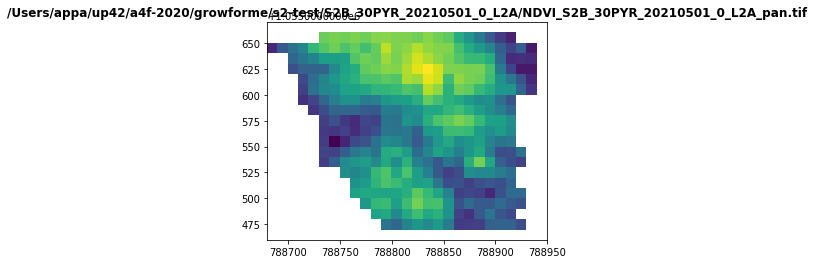

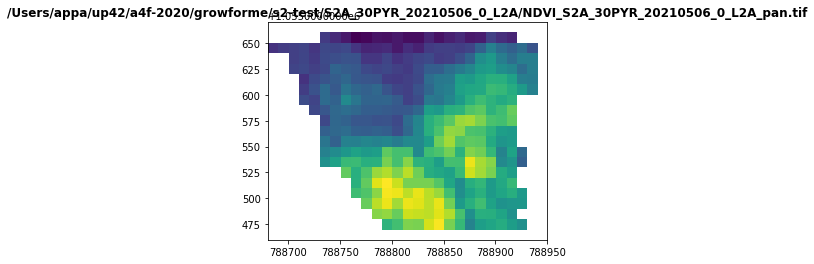

[<AxesSubplot:title={'center':'/Users/appa/up42/a4f-2020/growforme/s2-test/S2B_30PYR_20210501_0_L2A/NDVI_S2B_30PYR_20210501_0_L2A_pan.tif'}>,
 <AxesSubplot:title={'center':'/Users/appa/up42/a4f-2020/growforme/s2-test/S2A_30PYR_20210506_0_L2A/NDVI_S2A_30PYR_20210506_0_L2A_pan.tif'}>]

In [25]:
[rio.plot.show(rio.open(fn), title = fn) for fn in [f"{v}" for v in Path(my_outdir).glob("**/NDVI_*")]]

#### EVI

In [26]:
%%bash

OUTDIR=/Users/appa/up42/a4f-2020/growforme/s2-test/

# Looping on all the files.
for i in $(find $OUTDIR -type f -name 'S2*_pan.tif' -print); do
    # PATH needs to be passed to locate the script and the Python modules (osgeo) needed by gdal_calc.
    PATH=/usr/local/bin gdal_calc.py \
        -A $i --A_band=8 \
        -B $i --B_band=4 \
        -C $i --C_band=2 \
        --outfile=$(dirname $i)/EVI_$(basename $i) \
        --calc="2.5*(A-B)/(A+6*B-7.5*C+1)" --overwrite \
        --type=Float32 --NoData=0
done

0.. 100 - Done
0.. 100 - Done


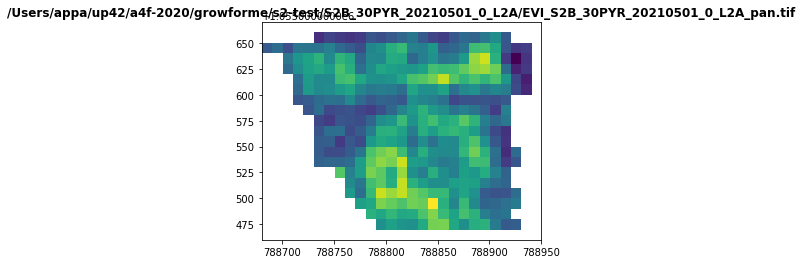

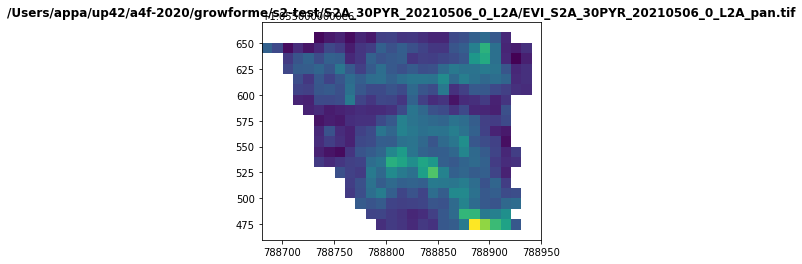

[<AxesSubplot:title={'center':'/Users/appa/up42/a4f-2020/growforme/s2-test/S2B_30PYR_20210501_0_L2A/EVI_S2B_30PYR_20210501_0_L2A_pan.tif'}>,
 <AxesSubplot:title={'center':'/Users/appa/up42/a4f-2020/growforme/s2-test/S2A_30PYR_20210506_0_L2A/EVI_S2A_30PYR_20210506_0_L2A_pan.tif'}>]

In [27]:
[rio.plot.show(rio.open(fn), title = fn) for fn in [f"{v}" for v in Path(my_outdir).glob("**/EVI_*")]]

### ARVI

In [28]:
%%bash

OUTDIR=/Users/appa/up42/a4f-2020/growforme/s2-test/

# Looping on all the files.
for i in $(find $OUTDIR -type f -name 'S2*_pan.tif' -print); do
    # PATH needs to be passed to locate the script and the Python modules (osgeo) needed by gdal_calc.
    PATH=/usr/local/bin gdal_calc.py \
        -A $i --A_band=8 \
        -B $i --B_band=4 \
        -C $i --C_band=2 \
        --outfile=$(dirname $i)/ARVI_$(basename $i) \
        --calc="(A-2*B+C)/(A+2*B+C)" --overwrite \
        --type=Float32 --NoData=0
done

0.. 100 - Done
0.. 100 - Done


<string>:1: RuntimeWarning: invalid value encountered in true_divide
<string>:1: RuntimeWarning: invalid value encountered in true_divide


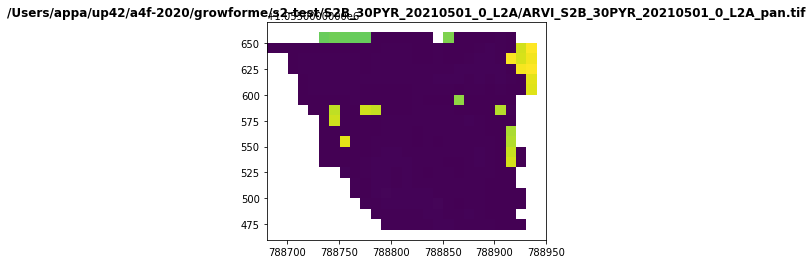

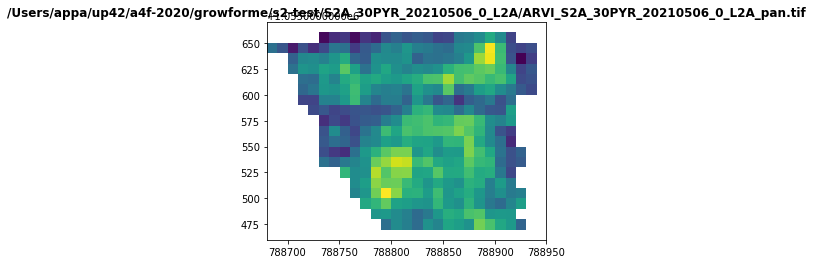

[<AxesSubplot:title={'center':'/Users/appa/up42/a4f-2020/growforme/s2-test/S2B_30PYR_20210501_0_L2A/ARVI_S2B_30PYR_20210501_0_L2A_pan.tif'}>,
 <AxesSubplot:title={'center':'/Users/appa/up42/a4f-2020/growforme/s2-test/S2A_30PYR_20210506_0_L2A/ARVI_S2A_30PYR_20210506_0_L2A_pan.tif'}>]

In [29]:
[rio.plot.show(rio.open(fn), title = fn) for fn in [f"{v}" for v in Path(my_outdir).glob("**/ARVI_*")]]

### SAVI

In [30]:
%%bash

OUTDIR=/Users/appa/up42/a4f-2020/growforme/s2-test/

# Looping on all the files.
for i in $(find $OUTDIR -type f -name 'S2*_pan.tif' -print); do
    # PATH needs to be passed to locate the script and the Python modules (osgeo) needed by gdal_calc.
    PATH=/usr/local/bin gdal_calc.py \
        -A $i --A_band=8 \
        -B $i --B_band=4 \
        --outfile=$(dirname $i)/SAVI_$(basename $i) \
        --calc="1.5*(A-B)/(A+B+0.5)" --overwrite \
        --type=Float32 --NoData=0
done

0.. 100 - Done
0.. 100 - Done


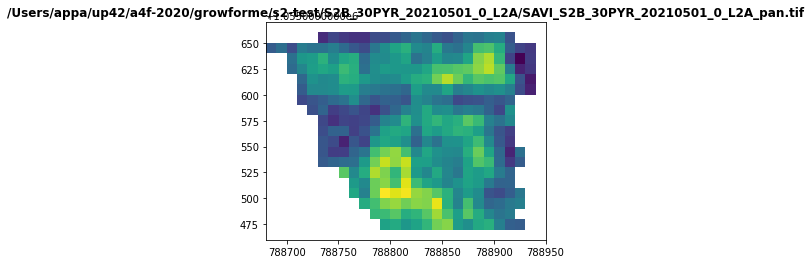

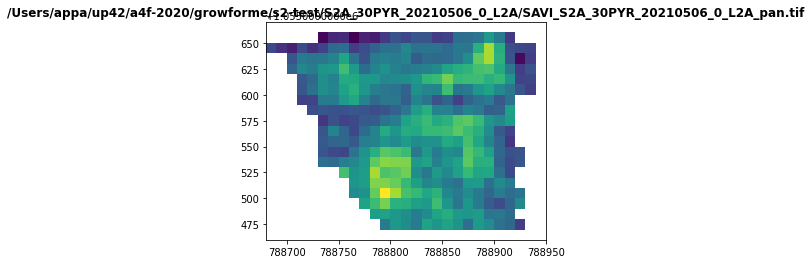

[<AxesSubplot:title={'center':'/Users/appa/up42/a4f-2020/growforme/s2-test/S2B_30PYR_20210501_0_L2A/SAVI_S2B_30PYR_20210501_0_L2A_pan.tif'}>,
 <AxesSubplot:title={'center':'/Users/appa/up42/a4f-2020/growforme/s2-test/S2A_30PYR_20210506_0_L2A/SAVI_S2A_30PYR_20210506_0_L2A_pan.tif'}>]

In [31]:
[rio.plot.show(rio.open(fn), title = fn) for fn in [f"{v}" for v in Path(my_outdir).glob("**/SAVI_*")]]